In [1]:
import sys
sys.path.insert(0,'../GroundingDINO')
sys.path.insert(0,'../SAM')
import os
import torch
import json
from pytorch3d.io import IO
import numpy as np
from src.utils import normalize_pc,save_colored_pc
from src.render_pc import render_pc
from src.gen_superpoint import gen_superpoint
from groundingdino.util.inference import load_model, load_image, predict, annotate
import cv2
from torchvision.ops import nms
import json
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import distinctipy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
def yolobbox2bbox(yolobox):
    x = yolobox[:,0]
    y = yolobox[:,1]
    w = yolobox[:,2]
    h = yolobox[:,3]
    xyxy = np.zeros_like(yolobox)
    xyxy[:,0] = x-w/2
    xyxy[:,1] = y-h/2
    xyxy[:,2] = x+w/2
    xyxy[:,3] = y+h/2
    return xyxy

def toDinoPrompt(metaData,className):
    listOfParts = metaData[className]
    prompt = ""
    partList = {}
    for i,part in enumerate(listOfParts):
        prompt += f"{part} of {className}.".lower()
        partList[f"{part}".lower()] = i
    return prompt,partList

def check_pc_within_bbox(x1, y1, x2, y2, pc):  
    flag = np.logical_and(pc[:, 0] > x1, pc[:, 0] < x2)
    flag = np.logical_and(flag, pc[:, 1] > y1)
    flag = np.logical_and(flag, pc[:, 1] < y2)
    return flag

def InferDINO(xyz, rgb,pc_idx, screen_coords, file,category,metaData,modelDINO,predictorSAM,device,BOX_TRESHOLD = 0.2, TEXT_TRESHOLD = 0.3, SCORE_THRESHOLD=0.2,n_neighbors=21,n_pass=3, save_dir="tmp"):
    TEXT_PROMPT,partList = toDinoPrompt(metaData,category)
    
    code = str(file.split("/")[-1])
    
    preds = []
    preds_dino = []
    for i in range(pc_idx.shape[0]):
        image_source, image = load_image(f"examples/zeroshot_Chair/rendered_img_test/{code}/{i}.png") #load rgb images
        predictorSAM.set_image(image_source)

        boxes, logits, phrases = predict(
                                        model=modelDINO,
                                        image=image,
                                        caption=TEXT_PROMPT,
                                        box_threshold=BOX_TRESHOLD,
                                        text_threshold=TEXT_TRESHOLD
                                    )
        phrases = np.array(phrases) #just to fix indexing

        xyxy = yolobbox2bbox(boxes)*image.shape[-1] #change bbox format to xyxy and scale with image size
        
        nms_mask = []
        for t,bbox in enumerate(xyxy): 
            if check_pc_within_bbox(bbox[0], bbox[1], bbox[2], bbox[3], screen_coords[i]).mean() < 0.95: 
                nms_mask.append(t)
                
        xyxy = xyxy[nms_mask]
        boxes = boxes[nms_mask]
        logits = logits[nms_mask]
        phrases = phrases[nms_mask]
        
        
        
        nms_indexes = nms(torch.tensor(xyxy) , logits, 0.5).numpy() #non maximum supression
        
        xyxy = xyxy[nms_indexes]
        boxes = boxes[nms_indexes]
        logits = logits[nms_indexes]
        phrases = phrases[nms_indexes]
        
        final_indexes = []
        new_phrases = []
        for iindex,part in enumerate(phrases):
            for metaPart in metaData[category]:
                if part.find(metaPart) != -1:
                    final_indexes.append(iindex)
                    new_phrases.append(metaPart)
                    
        
        xyxy = xyxy[final_indexes]
        boxes = boxes[final_indexes]
        logits = logits[final_indexes]
        phrases = np.array(new_phrases)
        preds_dino.append({"image_source":image_source,"xyxy":xyxy[final_indexes],"boxes":boxes[final_indexes],"logits":logits[final_indexes],"phrases":new_phrases})
        
        input_boxes = torch.tensor(xyxy, device=predictorSAM.device)    
        transformed_boxes = predictorSAM.transform.apply_boxes_torch(input_boxes, image_source.shape[:2])
        

        if transformed_boxes.shape[0] > 0:
            masks, _, _ = predictorSAM.predict_torch(
                point_coords=None,
                point_labels=None,
                boxes=transformed_boxes,
                multimask_output=False,
            )    #create segmentation masks with sam

            for index,mask in enumerate(masks):
#                 print(mask[1:].shape)
                preds.append({'image_id': i, 'category_id': phrases[index], 
                              'bbox': boxes[index]*image.shape[-1], 
                              'score': logits[index],
                              'mask':mask[0],
                              'image_source':image_source
                             }
                            )
    pc_aggMask = torch.zeros((xyz.shape[0],len(partList)+1)) #this is a segment agg mask we sum all the scores from our bboxes 
    #into their own respective channel, the last channel is for unsegmented parts
    pc_aggMask[:,-1] = SCORE_THRESHOLD #we can set a confidence threshold by setting the unsegmented score
    for prediction in preds:
        maskedPC_idx = pc_idx[prediction["image_id"],prediction["mask"].cpu().numpy()] #this gives you the pc idx of the points that are inside the mask
        index_pcMasked = np.unique(maskedPC_idx)[1:] # we only need the unique idx and the first id is always -1 meaning not found
        pc_aggMask[index_pcMasked,partList[prediction["category_id"]]] += prediction["score"] #add up all the scores for each part
    pc_seg_classes = torch.argmax(pc_aggMask,dim=-1) #select the highest score as our segmentation class
    #if non of the part scores are over the SCORE_THRESHOLD it will be left unsegmented
    partColors = np.array(distinctipy.get_colors(len(partList)))
    accumulator = np.zeros((xyz.shape[0], len(partList)+1))
    accumulator[:,-1] = 1
    # since projections are not exact meaning not every PC point is rendered into our image our backprojections are not dense
    # use KNN to smooth these backprojections 
    nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree').fit(xyz) #create a knn
    
    results = {"partseg_rgbs":{}}
    
    os.makedirs(f"{save_dir}/semantic_segDino_KNN/{code}", exist_ok=True)
    for colorId,part in enumerate(partList):
        pc_part_idx = np.zeros((xyz.shape[0]),dtype=int)
        rgb_sem = np.zeros((xyz.shape[0],3))
        pc_part_idx[torch.where(pc_seg_classes==partList[part])] = 1
        
        for pass_ in range(n_pass):
            notColoredIndexes = torch.where(pc_seg_classes!=partList[part]) #find non segmented parts for smoothing

            n_indexes = nn.kneighbors(xyz[notColoredIndexes],n_neighbors+1,return_distance=False)
            n_indexes = n_indexes[:,1:] #get n_neighbors for the points, the first index is always the point itself so delete that
            #we have dense point clouds so distance based measures are not necessary and sometimes give worst results
            flag = pc_part_idx[n_indexes].mean(axis=1) 
            
            flag[np.where(flag>=0.4)] = 1 #and segmnent the points where the mean of neighbours are colored %40 or over
            flag[np.where(flag<0.4)] = 0
            pc_part_idx[notColoredIndexes] = flag
           
        rgb_sem[pc_part_idx.astype(bool)] = partColors[colorId]
        accumulator[pc_part_idx.astype(bool),colorId] += 1
        save_colored_pc(f"{save_dir}/semantic_segDino_KNN/{code}/{part}.ply", xyz, rgb_sem)
        results["partseg_rgbs"][part] = rgb_sem
        
    pc_partIDX = np.argmax(accumulator,axis=-1)
    partColors_extended = np.append(partColors,[[0,0,0]],axis=0)
    
    save_colored_pc(f"{save_dir}/semantic_segDino_KNN/{code}/{category}.ply", xyz, partColors_extended[pc_partIDX.astype(int)]) 
    
    results["partList"] = partList
    results["xyz"] = xyz
    return results, preds, preds_dino

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)

device

device(type='cuda', index=0)

In [8]:
metaData = json.load(open("./PartNetE_meta.json")) 
device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
modelDINO = load_model("../GroundingDINO/groundingdino/config/GroundingDINO_SwinB_cfg.py",
                    "../GroundingDINO/weights/groundingdino_swinb_cogcoor.pth",
                    device=device
                    )
sam_checkpoint = "../SAM/weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")

predictorSAM = SamPredictor(sam)

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
toDinoPrompt(metaData, "Chair")

('arm of chair.back of chair.leg of chair.seat of chair.wheel of chair.',
 {'arm': 0, 'back': 1, 'leg': 2, 'seat': 3, 'wheel': 4})

In [9]:
from demo import InferGLIP

from src.glip_inference import load_model_glip

config ="GLIP/configs/glip_Swin_L.yaml"
weight_path = "models/glip_large_model.pth"
#     print("[loading GLIP model...]")
glip_demo = load_model_glip(config, weight_path)


for category, file in [("Chair", "44729")]:
    file = f"data/{category}/{file}"
    print(category +" inference DINO, GLIP ==> SAM started" +":")
    #for file in file_items:
    save_dir = f'examples/zeroshot_{category}'
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(f"{save_dir}/rendered_img", exist_ok=True) #create the necessary save directories
    os.makedirs(f"{save_dir}/dino_pred", exist_ok=True)
    os.makedirs(f"{save_dir}/semantic_segDino_KNN", exist_ok=True)

    io = IO()
    xyz, rgb = normalize_pc(file + "/pc.ply", save_dir, io, device) #read Point cloud and rgb in the format n,3

    code = str(file.split("/")[-1])
    pcidx_screencoords = np.load(f'examples/zeroshot_{category}/rendered_img_test/{code}/pcidx_screencoords.npz')

    pc_idx = pcidx_screencoords["pc_idx"]
    screen_coords = pcidx_screencoords["screen_coords"]

    print("----DINO Inference Starting----")
    preds, images, preds_dino = InferDINO(xyz, rgb, pc_idx, screen_coords, file, category, metaData,modelDINO,predictorSAM, device, BOX_TRESHOLD = 0.2,
                        TEXT_TRESHOLD = 0.3, save_dir=f'examples/zeroshot_{category}_drawio')

    print("----DINO Inference Completed---")
    print("mIOU CALCULATION DINO, " + category + ":")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceba

Chair inference DINO, GLIP ==> SAM started:
----DINO Inference Starting----


----DINO Inference Completed---
mIOU CALCULATION DINO, Chair:


In [14]:
imgResults = []
for prediction in preds_dino:
    annotated_frame = annotate(image_source=prediction["image_source"], boxes=prediction["boxes"], 
                               logits=prediction["logits"], phrases=prediction["phrases"])
    
    imgResults.append(annotated_frame)
    

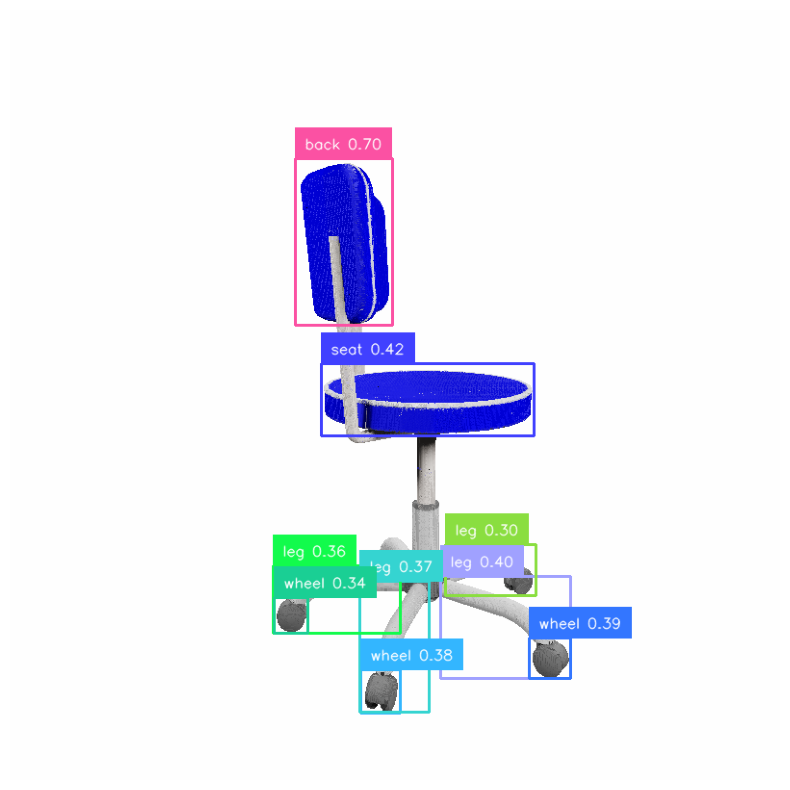

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(imgResults[3])

plt.axis('off')
plt.savefig('image_result_3.png', dpi=300, bbox_inches='tight')

# Optional: show the plot (if needed)
plt.show()

In [8]:
def load_imgs(file_name):
        pil_images = []

        for i in range(6):
            pil_images.append(np.array(Image.open(f"{file_name}/images/{i}.png").convert("RGB"))[:, :, [2, 1, 0]])
        return pil_images

class ShapeNetParts(torch.utils.data.Dataset):
    metaData = json.load(open("./PartNetE_meta.json",'r'))
    def __init__(self, split):
        assert split in ['train', 'val', 'test']
        self.items = glob(f"./data/*/*")
    def __getitem__(self, index):
        path = self.items[index]

        #pointcloudImages = load_imgs(path)
        segmentation_labels = np.load(f"{path}/label.npy",allow_pickle=True).item()
        return {
            'class': path.split("/")[-2],
            'path': path,
            'segmentation_labels': segmentation_labels["semantic_seg"]
        }
    def __len__(self):
        return len(self.items)

In [9]:
dataset_test = ShapeNetParts("test")
dataloader_test = torch.utils.data.dataloader.DataLoader(dataset_test,batch_size=1,shuffle=False)

In [10]:
io = IO()

In [15]:
correct_p = 0
total_p = 0
for batch in tqdm(dataloader_test):
    xyz, rgb = normalize_pc(pc_file=batch["path"][0], save_dir="",io=io, device=device)
    img_list, pc_idx, screen_coords = render_pc_no_vis(xyz, rgb, device)
    preds = glip_inference_noLoad(glip_demo,img_list ,ShapeNetParts.metaData[batch["class"][0]])
    superpoint = gen_superpoint(xyz, rgb, visualize=False, save_dir="")
    sem_seg, ins_seg = bbox2seg(xyz, superpoint, preds, screen_coords, pc_idx, ShapeNetParts.metaData[batch["class"][0]], "test",solve_instance_seg=False,visualize=False)
    correct_p += (sem_seg == batch["segmentation_labels"][0].numpy()).sum()
    total_p += sem_seg.shape[0]

  0%|                                                                                          | 0/1906 [00:00<?, ?it/s]/rhome/kamburoglu/miniconda3/envs/partslip/lib/python3.9/site-packages/pytorch3d/transforms/transform3d.py:800: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
/rhome/kamburoglu/miniconda3/envs/partslip/lib/python3.9/site-packages/transformers/modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/rhome/kamburoglu/miniconda3/envs/partslip/lib/python3.9/site-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
  0%|                                                                               | 1/1906 [01:18<41:20:40, 78.13s/it]/rhome/kamburoglu/miniconda3/envs/partslip/lib/python3.9/si

KeyboardInterrupt: 

In [ ]:
print("Correctly Labeled #Points: ",correct_p)
print("Total #Points: ",total_p)
print("Accuracy: %",100*correct_p/total_p)